# How's My Business

An analysis of an E-Commerce business, understanding of where they are at now, and knowing the holes of the business. The dataset is based off of [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/online+retail), which is mad eup of transactional data. The business is an online retail store business, based off of the UK, that sells all-occasion gifts.  

In [1]:
#load the necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

%matplotlib inline
plt.style.use("ggplot")

#read csv file
df = pd.read_csv("data.csv", encoding= 'unicode_escape')

In [2]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Attribute Information:

1. InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
2. StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
3. Description: Product (item) name. Nominal.
4. Quantity: The quantities of each product (item) per transaction. Numeric.
5. InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
6. UnitPrice: Unit price. Numeric, Product price per unit in sterling.
7. CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
8. Country: Country name. Nominal, the name of the country where each customer resides.

# Data Cleaning

Before doing any analysis on the data, there has to be some data quality checking first and cleaning of the dataset. This will be broken by inspecting for any missing data, handling it, and adding in new parameters that would better describe the business.

## Where's the Data?

Finding any missing data from the dataframe.

In [3]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [4]:
print("There's over {:.2f}% of the total data is missing from the Description column".format(df[df["Description"].isnull() == True].shape[0]/df.shape[0]*100))

There's over 0.27% of the total data is missing from the Description column


In [5]:
print("There's over {:.2f}% of the total data is missing from the CustomerID column".format(df[df["CustomerID"].isnull() == True].shape[0]/df.shape[0]*100))

There's over 24.93% of the total data is missing from the CustomerID column


The "Description" column, barely has any missing values which can be easily deleted off of the dataframe. However, the "CustomerID" feature has a large missing data, and needs to be examined closely to decide on how to fill in the missing cells.

In [6]:
#remove missing data from the Description column
df = df[df["Description"].isnull() == False]

Missing data under the "Description" columns has been removed.

In [7]:
df[df["CustomerID"].isnull() == True].sample(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
435250,574074,22944,CHRISTMAS METAL POSTCARD WITH BELLS,24,11/2/2011 15:33,0.97,NaN,United Kingdom
490997,578065,85170B,SET/6 BLACK BIRD T-LIGHT CANDLES,1,11/22/2011 15:41,4.13,NaN,United Kingdom
312092,C564340,AMAZONFEE,AMAZON FEE,-1,8/24/2011 14:50,4527.65,NaN,United Kingdom
63918,541592,22074,6 RIBBONS SHIMMERING PINKS,15,1/19/2011 15:08,0.83,NaN,United Kingdom
36146,539437,85203,HANGING WOOD AND FELT BUTTERFLY,2,12/17/2010 14:54,0.84,NaN,United Kingdom
351933,567670,21931,JUMBO STORAGE BAG SUKI,2,9/21/2011 15:32,4.13,NaN,United Kingdom
278320,561209,23321,SMALL WHITE HEART OF WICKER,4,7/25/2011 16:57,3.29,NaN,United Kingdom
108889,545568,85204,HANGING WOOD AND FELT FLOWER,1,3/3/2011 16:22,0.42,NaN,United Kingdom
416478,572553,20777,CHRYSANTHEMUM NOTEBOOK,1,10/24/2011 17:09,1.63,NaN,United Kingdom
16057,537643,22501,PICNIC BASKET WICKER LARGE,1,12/7/2010 15:34,21.23,NaN,United Kingdom


Missing CustomerID's are not coming from cancelled transactions. One possible  reason for this would probably be some error coming from their backend. What's going to happen is that the missing CustomerID's will get their own, coming from the invoice number. This does assume that all CustomerID's are going to have only a single transaction.

In [8]:
#check if there are any InvoiceNo existing in the CustomerID column
invoice = df["InvoiceNo"].unique().tolist()

df[df["CustomerID"].isin(invoice)].shape

(0, 8)

There's no overlap between the InvoiceNo and CustomerID. The invoice number will fill in the missing CustomerID data.

In [9]:
#fill in missing customerID data with the InvoiceNo
df["CustomerID"] = df["CustomerID"].fillna(df["InvoiceNo"])

In [10]:
#check again for any missing data
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

## Feature Engineering

The analysis will be based mainly off of the sales of the business, so the features will revolve around this business aspect. The following will be added into the dataframe:

1. Turning the date column into a datetime dtype. Very useful when plotting time series data.
2. Adding in Total sales which is the product between the price and quantity being purchased.
3. Add in any repeat or first time purchasers, to understand churn rate.
4. Transaction number for each customer. 

In [11]:
#turn InvoiceDate into DateTime Column
df["DateTime"] = pd.to_datetime(df["InvoiceDate"])
df["Date"] = df["DateTime"].dt.date
df["year"] = df["DateTime"].dt.year
df["month"] = df["DateTime"].dt.month
df["dow"] = df["DateTime"].dt.dayofweek
df["month_year"] = df["DateTime"].dt.to_period("M")

#Total sales of each item bought
df["Total Sales"] = df["Quantity"]*df["UnitPrice"]

#find out any repeat customers
customer_status = df[["InvoiceNo", "CustomerID"]].drop_duplicates().groupby("CustomerID").agg({"InvoiceNo":"nunique"}).reset_index()
customer_status.columns = ["CustomerID", "Transactions"]

customer_status["Purchaser Status"] = np.where(customer_status["Transactions"] == 1, "First Time Purchaser", "Repeat Purchaser")

df = df.merge(customer_status[["CustomerID", "Purchaser Status"]], on = "CustomerID")

#added transaction number
transaction_n = df[["InvoiceDate", "CustomerID", "InvoiceNo"]].drop_duplicates()
transaction_n["Transaction"] = transaction_n.groupby(["CustomerID"]).cumcount()+1

df = df.merge(transaction_n, on = ["CustomerID", "InvoiceNo", "InvoiceDate"])

# Is My Business Doing Well?

Sales will be the main focus on the analysis. This section will be focused on understanding the different sales aspects of the business, and how other things can be changed to improve it.

## General

In [12]:
cancelled_trans = df["InvoiceNo"].str.match("^C.*") == True
returned_items = df["Quantity"] > 0
not_december2011 = df["DateTime"] < '2011-12-01'

clean_df = df[~(cancelled_trans) & (returned_items) & (not_december2011)] 

sales = clean_df.groupby("month_year").agg({"Total Sales":"sum"}).reset_index()
transactions = clean_df.groupby("month_year").agg({"InvoiceNo":"nunique"}).reset_index()

#create a custom paramater for sales dataframe
sales["MoM Sales Growth"] = (sales["Total Sales"] - sales["Total Sales"].shift(1))/sales["Total Sales"].shift(1)*100

Note: A different dataset has been used called "clean_df" which removes all the transactions that have been cancelled, returned, as well as excluding December 2011 because it only had 9 days worth of recorded transactions.

Definitions:
1. Cancelled Transactions = All the Invoices that had cancelled their transaction, which can be shown by a C at the start of the Invoice ID.
2. Returned Items = Items that have a negative value to them.
3. Not December 2011 = All transactions that have been done before December 2011.

In [13]:
first_time = clean_df[clean_df["Purchaser Status"] == "First Time Purchaser"]["CustomerID"].nunique()
repeat = clean_df[clean_df["Purchaser Status"] == "Repeat Purchaser"]["CustomerID"].nunique()

print("Total Succesful Sales: £{:,.0f}".format(sales["Total Sales"].sum()))
print("Total Transactions: {:,.0f}, but only {:,.0f} transactions have pulled through".format(df["InvoiceNo"].nunique(), clean_df["InvoiceNo"].nunique()))
print("Total Customers: {:,.0f}, where {:,} are first time customers and {:,} are repeat purchasers.".format(clean_df["CustomerID"].nunique(), first_time, repeat))
print("\nThere's over {:,} cancelled transactions with a total sales of £{:,.2f}. Which consists to about 6% of the total sales.".format(df[cancelled_trans & not_december2011]["InvoiceNo"].nunique(), 
                                                                                abs(df[cancelled_trans & not_december2011]["Total Sales"].sum())))
print("The remaining 1,450 transactions are returned items that have been missing or damaged. ")

#print("Average Order Size is £{:,.2f}".format(clean_df.groupby("InvoiceNo").agg({"Total Sales":"sum"})["Total Sales"].median()))

Total Succesful Sales: £10,005,768
Total Transactions: 24,446, but only 19,307 transactions have pulled through
Total Customers: 5,847, where 2,794 are first time customers and 3,053 are repeat purchasers.

There's over 3,690 cancelled transactions with a total sales of £691,687.82. Which consists to about 6% of the total sales.
The remaining 1,450 transactions are returned items that have been missing or damaged. 


Note: The total sales cannot be calculated because the price wasn't being added in the dataframe.

## Sales

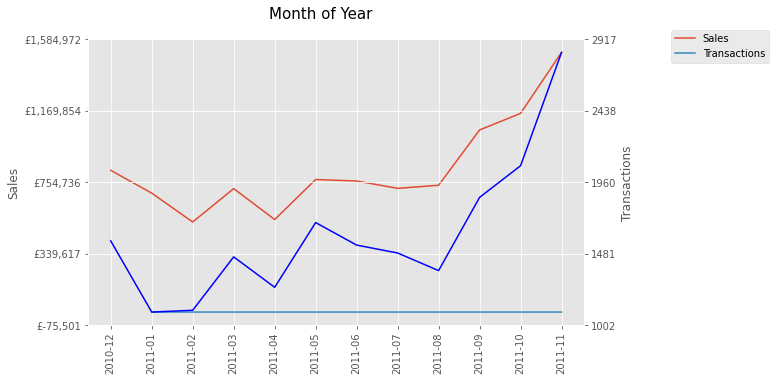

In [14]:
#create plot
fig, ax1 = plt.subplots(figsize = (9, 5))

#sales
sales.plot(ax=ax1, legend = False)

ax1.set_xticks(np.arange(len(sales["month_year"].unique())))
ax1.set_xticklabels(sales["month_year"].unique(), rotation = 90)

fmt = '£{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick) 
ax1.set_ylabel("Sales")


#transactions
ax2 = ax1.twinx()
transactions.plot(ax=ax2, color = "blue", legend = False)

ax2.set_ylabel("Transactions")

ax1.set_yticks(np.linspace(ax1.get_ybound()[0], ax1.get_ybound()[1], 5))
ax2.set_yticks(np.linspace(ax2.get_ybound()[0], ax2.get_ybound()[1], 5))

fig.legend(["Sales", "Transactions"], bbox_to_anchor = (1.2,1))
plt.tight_layout()
plt.suptitle("Month of Year", fontsize = 15, y = 1.05);

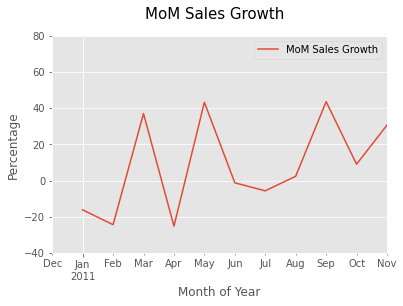

In [15]:
sales.plot(x = "month_year", y = "MoM Sales Growth")

plt.ylim([-40,80])
plt.suptitle("MoM Sales Growth", fontsize = 15)
plt.ylabel("Percentage")
plt.xlabel("Month of Year");

Sales for the last 3 months have shown to be skyrocketing, which is well supported with the Mom growth as well. From September onwards, there's an average of 27% MoM growth. This implies that the company has had a succesful marketing campaign as well as a tight product-market fit. It does not show any signs of plateauing, and can still increase for the next few months.

## New Customers vs Returning Customers

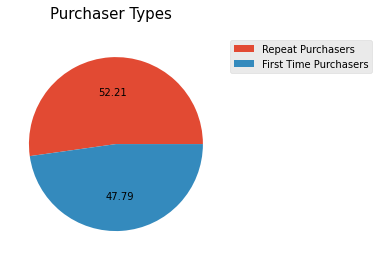

In [16]:
purchasers = clean_df[["CustomerID", "Purchaser Status"]].drop_duplicates()

purchasers["Purchaser Status"].value_counts().plot(kind = "pie", autopct = "%.2f", labels = None)
plt.legend(["Repeat Purchasers", "First Time Purchasers"], bbox_to_anchor = (1,1))
plt.suptitle("Purchaser Types", fontsize = 15)
plt.ylabel("");

Extremely high retention rate, with over 50% of the customers have made a repeat purchase.

In [17]:
#check AOV of repeat vs first time purchasers
purchasers = clean_df.groupby(["CustomerID", "Purchaser Status"]).agg({"InvoiceNo":"nunique",
                                                                                                              "Total Sales":"sum"}).reset_index()
purchasers.columns = ["CustomerID","Purchaser Status", "Transactions", "Total Sales"]
purchasers["User"] = 1

In [18]:
purchasers.groupby("Purchaser Status").agg({"Transactions":"median"})

,Transactions
Purchaser Status,
First Time Purchaser,1
Repeat Purchaser,3


It is expected that a repeat purchaser would do atleast 3 purchases before churning.

In [19]:
def ARPU(group):
    d = group['Total Sales']
    w = group['User']
    return d.sum() / w.sum()

def AOV(group):
    d = group['Total Sales']
    w = group['Transactions']
    return d.sum() / w.sum()

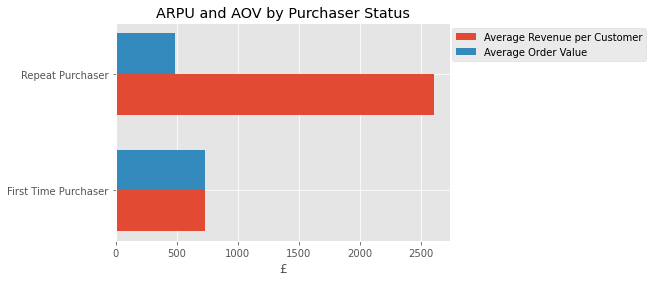

In [20]:
arpu = purchasers.groupby("Purchaser Status").apply(ARPU)
aov = purchasers.groupby("Purchaser Status").apply(AOV)

labels = arpu.index
arpu = arpu[:]
aov = aov[:]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.barh(x - width/2, arpu, width, label='Average Revenue per Customer')
rects2 = ax.barh(x + width/2, aov, width, label='Average Order Value')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('£')
ax.set_title("ARPU and AOV by Purchaser Status")
ax.set_yticks(x)
ax.set_yticklabels(labels)
ax.legend(bbox_to_anchor = (1.6, 1));

AOV for a repeat customer is lower than a first time purchaser which shows that succeeding transactions have slightly lesser sales. To improve AOV of a repeat purchaser, try doing cross-selling techniques to entice the customer to buy more items per transactions.

## Failed Transactions

In [21]:
total_trans = df.groupby("month_year")["InvoiceNo"].nunique().reset_index()
total_trans.columns = ["month_year", "total transactions"]

failed_trans = df[~(returned_items) & ~(cancelled_trans) & (not_december2011)].groupby("month_year")["InvoiceNo"].nunique().reset_index()
failed_trans.columns = ["month_year", "failed transactions"]

trans = total_trans.merge(failed_trans, on = ["month_year"])
trans["% Failed"] = trans["failed transactions"]/trans["total transactions"]*100

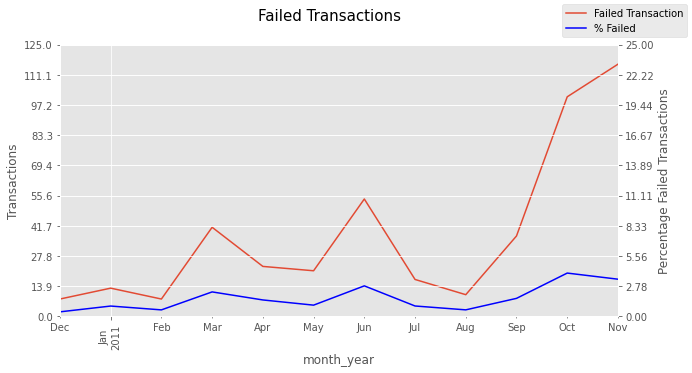

In [22]:
failed_trans = df[~(returned_items) & ~(cancelled_trans) & (not_december2011)].groupby("month_year")["InvoiceNo"].nunique().reset_index()

#create graph
fig, ax1 = plt.subplots(figsize = (10,5), sharex = True)

trans.plot(x = "month_year", y = "failed transactions", ax=ax1, legend = False)

ax1.set_xticks(np.arange(len(trans["month_year"].unique())))
ax1.set_xticklabels(trans["month_year"].unique(), rotation = 90)
ax1.set_ylabel("Transactions")

ax2 = ax1.twinx()
trans.plot(x = "month_year", y = "% Failed", ax=ax2, legend = False, color = "blue")

ax2.set_ylabel("Percentage Failed Transactions")


ax1.set_ylim([0,125])
ax2.set_ylim([0,25])

ax1.set_yticks(np.linspace(ax1.get_ybound()[0], ax1.get_ybound()[1], 10))
ax2.set_yticks(np.linspace(ax2.get_ybound()[0], ax2.get_ybound()[1], 10))

fig.legend(["Failed Transaction", "% Failed"])
plt.suptitle("Failed Transactions", fontsize = 15);

The % of failed transactions have shown to be increasing in the last 2 months of operation, which is over 3%. There could be problems of scaling in the future that the more transactions the business is getting, cancelled and failed deals would increase as well. It would be best to take care of this, and minimize failed transactions to less than 1% as they can have a negative impact of the customer journey.

In [23]:
#effect of a cancelled transaction
last_trans = df.groupby(["CustomerID","InvoiceNo"])["Transaction"].max().reset_index()

print("There are a total of {:,.0f} failed transactions, and over {:,.0f} of those were their last time they bought in the retail store."\
     .format(df[cancelled_trans]["InvoiceNo"].nunique(),
            df[cancelled_trans & df["InvoiceNo"].isin(last_trans["InvoiceNo"].unique().tolist())]["InvoiceNo"].nunique()))

There are a total of 3,836 failed transactions, and over 3,836 of those were their last time they bought in the retail store.


100% of failed transactions are the customer's last time they purchased in the store. Improving customer journey and the company's last mile delivery system can help decrease any missing and damaged items, as well as boost's the customer's confidence with the business.

## Purchaser Behavior

Now that there's a good understanding of the business, let's look at the most recent purchaser behavior. Recent here is defined as the last 3 months, which would be from September onwards. This can be used to identify which existing customers have high traction with the business and the lapsing users as well.

Note: I only used the last 3 months because using old data, would imply that that customer has the same level of engagement as they are in the present.

In [24]:
def recency(date):
    return (pd.to_datetime("2011-12-10") - date.max()).days

In [25]:
rfm = df[~(cancelled_trans) & (returned_items) & (df["DateTime"] >= "2011-09-01")].groupby("CustomerID").agg({"InvoiceNo":"nunique", "Total Sales":"sum", "DateTime":recency}).reset_index()
rfm.columns = ["CustomerID", "Frequency", "Monetary", "Recency"]

In [26]:
def score(parameter):
    percentile_20 = rfm[parameter].quantile(0.2)
    percentile_40 = rfm[parameter].quantile(0.4)
    percentile_60 = rfm[parameter].quantile(0.6)
    percentile_80 = rfm[parameter].quantile(0.8)
    
    condlist = [rfm[parameter] < percentile_20,             
                (rfm[parameter] >= percentile_20) & (rfm[parameter] < percentile_40),
               (rfm[parameter] >= percentile_40) & (rfm[parameter] < percentile_60),
               (rfm[parameter] >= percentile_60) & (rfm[parameter] < percentile_80),
               rfm[parameter] >= percentile_80]
    if parameter == "Monetary":
        choicelist = [1,2,3,4,5]
    else: choicelist = [5,4,3,2,1]

    return np.select(condlist, choicelist)

In [27]:
condlist = [rfm["Frequency"] == 1,             
            (rfm["Frequency"] >= 2) & (rfm["Frequency"] < 6),
            (rfm["Frequency"] >= 6) & (rfm["Frequency"] < 12),
            (rfm["Frequency"] >= 12) & (rfm["Frequency"] < 20),
            rfm["Frequency"] >= 20]
choicelist = [1,2,3,4,5]

rfm["f_score"] = np.select(condlist, choicelist)
rfm["m_score"] = score("Monetary")
rfm["r_score"] = score("Recency")

Note: I used a different method to group up the Frequency, mainly because most of the data is under frequency = 1, and doing quantile percentage on it would only lead to having the same results. I tried doing it, and the results at 50% and 20% percentile is the same which is at 1.

In [28]:
#new customers
new_customers = rfm[(rfm["r_score"] == 5) & (rfm["f_score"] <= 2)].shape[0]
#Whales
whales = rfm[(rfm["r_score"] >= 4) & (rfm["f_score"] >= 4) & (rfm["m_score"] >= 4)].shape[0]
#lapsed customers
lapsed_customers = rfm[(rfm["r_score"] <= 2) & (rfm["m_score"] >= 4)].shape[0]

print("There are a total of {:,} customers during this period.".format(rfm["CustomerID"].nunique()))
print("For the past 3 months, there are over {} new customers.".format(new_customers))
print("The business has also identified {} highly engaged users".format(whales))
print("However, there are {} customers who have contributed a lot of sales, but recently haven't been active.".format(lapsed_customers))

There are a total of 3,440 customers during this period.
For the past 3 months, there are over 516 new customers.
The business has also identified 31 highly engaged users
However, there are 360 customers who have contributed a lot of sales, but recently haven't been active.


A retargeting campaign should be done on both new and lapsed customers. it is very important to try retain customers as they are cheaper to engage in the website over a new one.
   1. For the new customers, the business can possibly do a digital marketing campaign that with the purpose of cross-selling to help entice the new customers to do it again.
   2. Lapsing customers, re-engagement by reminding them, or create a special sale.
   
A special promotional campaign can be used for the whales to help them retain in the business.

Lastly, for the customers who aren't part of any of the groups, a simple campaign showing any new items or general promotions can be done just to remind them of the business.

# What Should We Do Next?

The business has shown a massive growth of sales, and over 50% of the purchasers doing a repeat purchase. However, there still needs to be improvements along the operations.
   1. There's some issue on the % failed transactions and it scales along with the number of transactions. Optimization of the customer journey and last mile delivery could help minimize unsatisfied customers.
   
We have also identified several groups of customers which can be retargeted to sustain their level of engagement in the business.
   1. Creating digital campaigns to the identified customers and retargeting them with customized messaging to help retention.

# References

1. [UCI Machine Learning Dataset](https://archive.ics.uci.edu/ml/datasets/online+retail)
2. [E-Commerce KPIs](https://www.shopify.com/blog/7365564-32-key-performance-indicators-kpis-for-ecommerce)